In [1]:
import json
import math
import glob
import pickle
import random
import datetime
import itertools
from mip import *
import numpy as np
import pandas as pd
import numpy.random as rnd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as et 
from collections import defaultdict
# Import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
def iter_docs(author):
    author_attr = author.attrib
    for doc in author.iter('vehicle'):
        doc_dict = author_attr.copy()
        doc_dict.update(doc.attrib)
        #doc_dict['data'] = doc.text
        yield doc_dict

In [3]:
def iter_author(etree):
    for author in etree.iter('timestep'):
        for row in iter_docs(author):
            yield row

In [4]:
input_files = glob.glob("*.xml")[4:15]
input_files

['here.output00.xml',
 'here.output01.xml',
 'here.output02.xml',
 'here.output03.xml',
 'here.output04.xml',
 'here.output05.xml',
 'here.output06.xml',
 'here.output07.xml',
 'here.output08.xml',
 'here.output09.xml',
 'here.output10.xml']

In [5]:
dates = pd.date_range(start="2022-02-28",end="2022-03-10")
dates

DatetimeIndex(['2022-02-28', '2022-03-01', '2022-03-02', '2022-03-03',
               '2022-03-04', '2022-03-05', '2022-03-06', '2022-03-07',
               '2022-03-08', '2022-03-09', '2022-03-10'],
              dtype='datetime64[ns]', freq='D')

In [6]:
df = pd.DataFrame()
for i in range(10):
    data = et.parse(input_files[i])
    df1 = pd.DataFrame(list(iter_author(data)))
    df1['time'] = df1['time'].astype('float')
    df1['time'] = df1['time']
    df1['time'] = df1['time'].astype('int')
    df2 = pd.DataFrame(df1['time'].value_counts())
    df2 = df2.sort_index(ascending=True)
    df2.index = [str(dates[i])+" "+str(datetime.timedelta(seconds = index)) for index in df2.index]
    df2.index = pd.to_datetime(df2.index)
    if i== 0:
        df = df2
    else:
        df = pd.concat([df, df2])
df

,time
2022-02-28 00:05:00,7
2022-02-28 00:10:00,10
2022-02-28 00:15:00,14
2022-02-28 00:20:00,10
2022-02-28 00:25:00,7
...,...
2022-03-09 23:35:00,15
2022-03-09 23:40:00,14
2022-03-09 23:45:00,12
2022-03-09 23:50:00,18


In [7]:
df_re = df.resample('H').max()
df_re

,time
2022-02-28 00:00:00,14
2022-02-28 01:00:00,10
2022-02-28 02:00:00,10
2022-02-28 03:00:00,10
2022-02-28 04:00:00,11
...,...
2022-03-09 19:00:00,13
2022-03-09 20:00:00,15
2022-03-09 21:00:00,17
2022-03-09 22:00:00,17


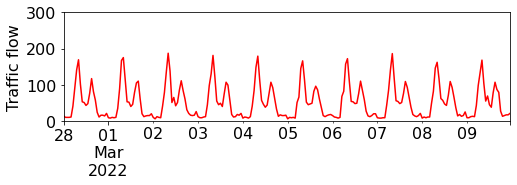

In [9]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (8,2)
df_re.plot(legend=None, c='r')
plt.grid()
plt.ylim(0,300)
plt.ylabel('Traffic flow')
plt.grid()
# xlim = np.arange(0, 60* 60 *24, 60*60*4)
# plt.xticks(xlim, [str(n).zfill(2) + ':00' for n in np.arange(0, 24, 4)])

In [ ]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(3, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [ ]:
train_data = df_re['2022-02-28':'2022-03-08']
test_data = df_re['2022-03-09':'2022-03-09']

In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [ ]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

In [ ]:
# Let's fit this model
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

In [ ]:
results.plot_diagnostics(figsize=(20, 14))
plt.show()

In [ ]:
pred0 = results.get_prediction(start='2022-03-07 00:00:00', dynamic=False)
pred0_ci = pred0.conf_int()
pred0_ci

In [ ]:
pred1 = results.get_prediction(start='2022-03-07 00:00:00', dynamic=True)
pred1_ci = pred1.conf_int()
pred1_ci 

In [ ]:
pred2 = results.get_forecast('2022-03-10 23:00:00')
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean['2022-03-09 00:00:00':'2022-03-09 23:00:00'])

In [ ]:
plt.rcParams.update({'font.size': 16})
ax = df_re.plot(figsize=(20, 10))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('Traffic Flow')
plt.xlabel('Time')
plt.legend()
plt.show()

In [ ]:
prediction = pred2.predicted_mean['2022-03-09 00:00:00':'2022-03-09 23:00:00'].values
# flatten nested list
truth = list(itertools.chain.from_iterable(test_data.values))
# Mean Absolute Percentage Error
MAPE = np.mean(np.abs((truth - prediction) / truth)) * 100

print('The Mean Absolute Percentage Error for the forecast of 2022-03-09 is {:.2f}%'.format(MAPE))

In [ ]:
prediction

In [ ]:
[round(i) for i in truth]